In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [52]:
df = pd.read_csv("./data/market/Palghar.Rice.csv")
df['Price Date'] = pd.to_datetime(df['Price Date'], format='%d %b %Y').dt.strftime('%Y-%m-%d')
df.drop(['Min Price (Rs./Quintal)','Max Price (Rs./Quintal)',], axis=1, inplace = True)
df.rename(columns={'Modal Price (Rs./Quintal)':'Price', 'Price Date': 'Date'}, inplace = True)
df.set_index('Date', inplace = True)
df.sort_index(inplace = True)
df.index = pd.to_datetime(df.index)
df

,Price
Date,
2014-12-31,2452
2015-01-01,1960
2015-01-02,2732
2015-01-03,3030
2015-01-05,2750
...,...
2024-02-29,4601
2024-03-01,4274
2024-03-02,4125


In [53]:

df = df.resample('D').first()

df['Price'].interpolate(method='linear', inplace=True)
df

C:\Users\jatin\AppData\Local\Temp\ipykernel_21776\2136546253.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].interpolate(method='linear', inplace=True)


,Price
Date,
2014-12-31,2452.0
2015-01-01,1960.0
2015-01-02,2732.0
2015-01-03,3030.0
2015-01-04,2890.0
...,...
2024-02-29,4601.0
2024-03-01,4274.0
2024-03-02,4125.0


In [54]:
df


,Price
Date,
2014-12-31,2452.0
2015-01-01,1960.0
2015-01-02,2732.0
2015-01-03,3030.0
2015-01-04,2890.0
...,...
2024-02-29,4601.0
2024-03-01,4274.0
2024-03-02,4125.0


In [55]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,3352.0,3486.59457,798.888528,1651.0,2975.423913,3375.0,3910.25,6201.0


In [56]:
print(df['Price'].min())

1651.0


In [57]:
print(df['Price'].min())

1651.0


<Axes: xlabel='Date'>

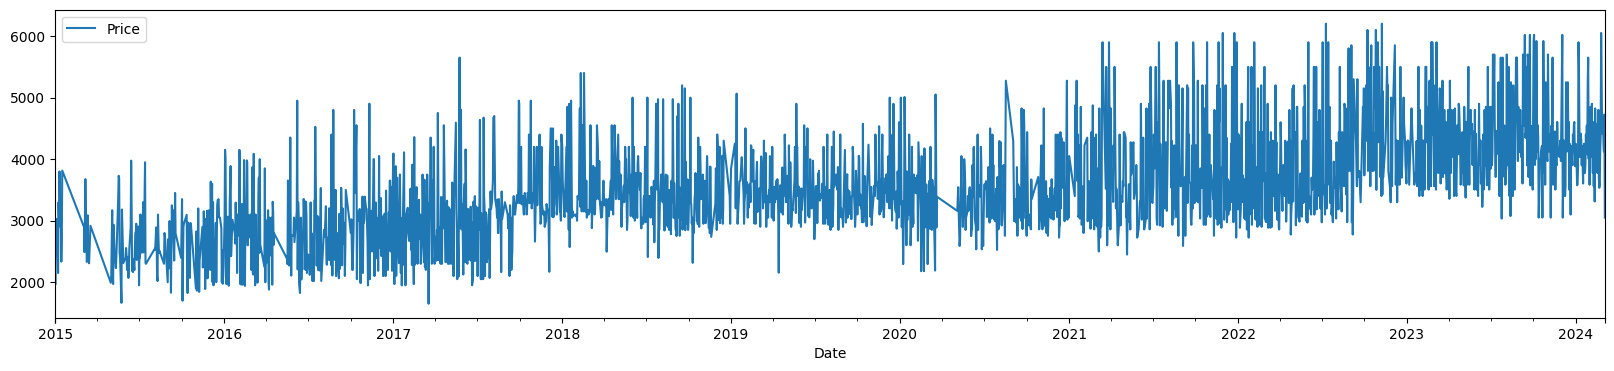

In [58]:
df.plot(figsize=(20, 4))

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [60]:
result = seasonal_decompose(df, model="multiplicative")

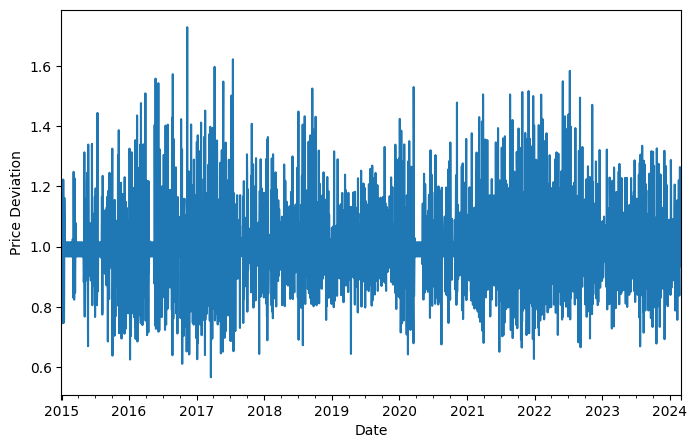

In [61]:
result.resid.plot(figsize=(8, 5))
plt.ylabel("Price Deviation")
plt.show()

In [62]:
PREDICTION_DAYS = 28

In [63]:
from sklearn.preprocessing import MinMaxScaler

In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [65]:
sequence_length = 56

In [66]:
X, y = [], []

sequences = []

for i in range(len(df) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[(i + sequence_length)][0])

X = np.array(X)
y = np.array(y)

In [67]:
X.shape, y.shape

((3296, 56, 1), (3296,))

In [68]:
split = int(0.8 * len(X))

In [69]:
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [70]:
X_train.shape
y_train.shape

(2636,)

In [71]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential(
    [
        LSTM(units=64, return_sequences=True, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=False),
        Dense(units=64,activation="relu"),
        Dense(units=1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")

In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 56, 64)            16896     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 54145 (211.50 KB)
Trainable params: 54145 (211.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
history = model.fit(X_train, y_train, batch_size=28, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50


95/95 [==============================] - 7s 38ms/step - loss: 0.0253 - val_loss: 0.0265
Epoch 2/50
95/95 [==============================] - 3s 29ms/step - loss: 0.0173 - val_loss: 0.0233
Epoch 3/50
95/95 [==============================] - 3s 30ms/step - loss: 0.0180 - val_loss: 0.0245
Epoch 4/50
95/95 [==============================] - 3s 30ms/step - loss: 0.0172 - val_loss: 0.0316
Epoch 5/50
95/95 [==============================] - 3s 31ms/step - loss: 0.0172 - val_loss: 0.0290
Epoch 6/50
95/95 [==============================] - 3s 30ms/step - loss: 0.0173 - val_loss: 0.0341
Epoch 7/50
95/95 [==============================] - 3s 30ms/step - loss: 0.0171 - val_loss: 0.0242
Epoch 8/50
95/95 [==============================] - 3s 30ms/step - loss: 0.0168 - val_loss: 0.0294
Epoch 9/50
95/95 [==============================] - 3s 31ms/step - loss: 0.0169 - val_loss: 0.0290
Epoch 10/50
95/95 [==============================] - 3s 31ms/step - loss: 0.0167 - val_loss: 0.0261
Epoch 11/50
95/95 [=

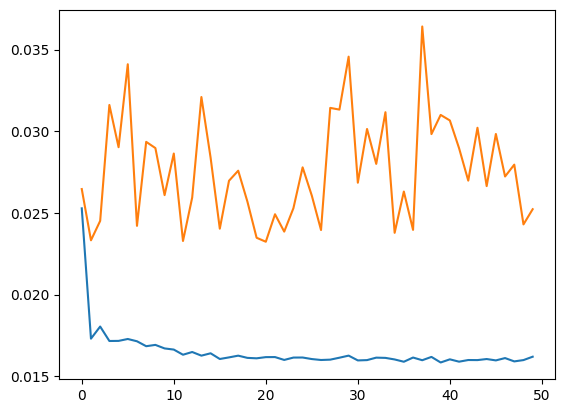

In [74]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [75]:
from joblib import dump, load

In [76]:
#model = load("./out/forecast.LSTM.Vasai.joblib")

In [77]:
x_test = scaled_data[-sequence_length:]
x_test = np.array([x_test])

In [78]:
x_test.shape

(1, 56, 1)

In [79]:
predictions = model.predict(X)

103/103 [==============================] - 2s 11ms/step


In [80]:
predictions = predictions.reshape(-1,1)
predictions = scaler.inverse_transform(predictions).flatten()


In [81]:
from datetime import timedelta

In [82]:
future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, 29)]

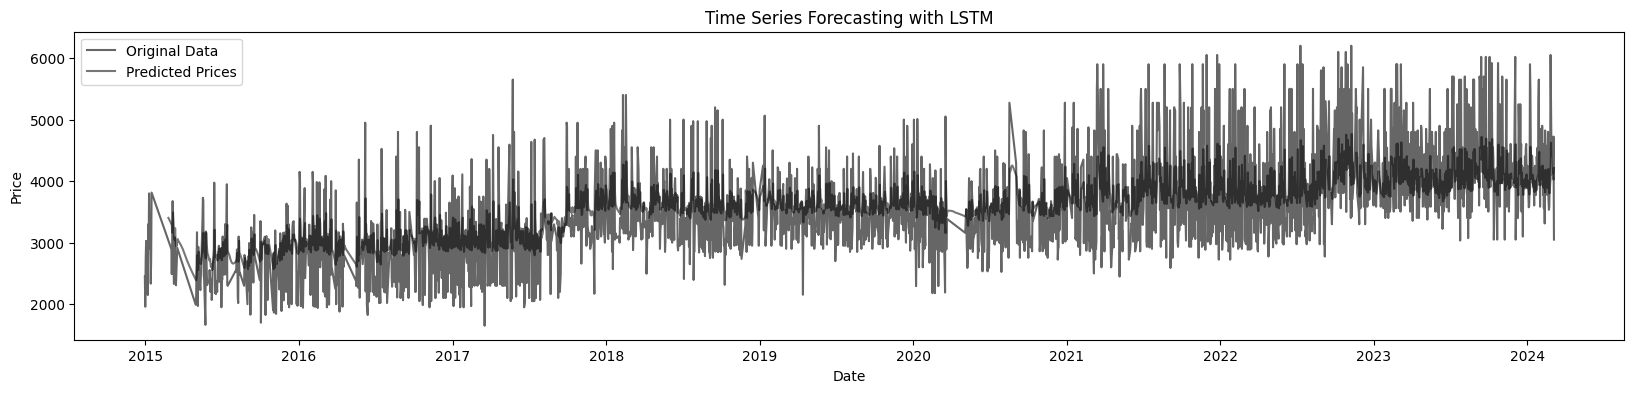

In [83]:
plt.figure(figsize=(20, 4))
plt.plot(df.index, df['Price'], label='Original Data', c="#666666")
plt.plot(df.index[sequence_length:], predictions, label='Predicted Prices', c="#00000088")
plt.title('Time Series Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

(
    mean_absolute_error(predictions, df["Price"][sequence_length:]),
    mean_squared_error(predictions, df["Price"][sequence_length:], squared=False),
)

C:\Users\jatin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(471.17749265670096, 615.2134408066929)